In [40]:
                                 #LSTM
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [41]:
# First, we get the data
dataset = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,34.29,34.29,33.20,33.52,9250100,MCD
2006-01-04,33.43,33.85,33.42,33.82,5990300,MCD
2006-01-05,33.82,34.20,33.73,33.86,6245200,MCD
2006-01-06,34.23,34.30,33.81,34.06,5877100,MCD
2006-01-09,34.00,34.74,33.99,34.71,4659900,MCD


In [43]:
total_null = df.isnull().sum().sort_values(ascending = False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
print("Total records = ", df.shape[0])

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
missing_data.head(10)

Total records =  3020


,Total Missing,In Percent
Open,1,0.03
High,1,0.03
Low,0,0.00
Close,0,0.00
Volume,0,0.00
Name,0,0.00


replacing each null with the mean of last 50 non-nan data

In [42]:
filled_dataset = dataset.copy()

# Find the positions of NaN values
nan_positions = np.where(pd.isna(filled_dataset))

# Iterate over each NaN position
for row, col in zip(*nan_positions):
    # Calculate the local mean of the previous 50 datasets
    start_row = max(0, row - 50)
    local_mean = filled_dataset.iloc[start_row:row, col].mean()
    
    # Replace the NaN value with the local mean
    filled_dataset.iloc[row, col] = local_mean

In [44]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [45]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real MCD Stock Price')
    plt.plot(predicted, color='blue',label='Predicted MCD Stock Price')
    plt.title('MCD Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('MCD Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [46]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

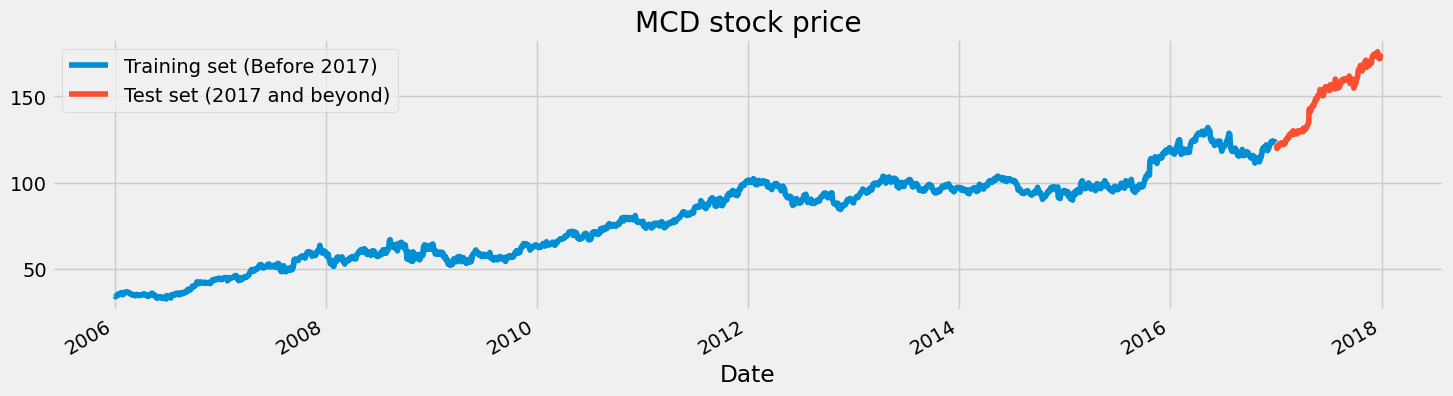

In [47]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('MCD stock price')
plt.show()

In [48]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [49]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [50]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [51]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 17s 116ms/step - loss: 0.0182
Epoch 2/50
85/85 [==============================] - 10s 118ms/step - loss: 0.0080
Epoch 3/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0067
Epoch 4/50
85/85 [==============================] - 10s 115ms/step - loss: 0.0056
Epoch 5/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0053
Epoch 6/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0042
Epoch 7/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0039
Epoch 8/50
85/85 [==============================] - 10s 119ms/step - loss: 0.0037
Epoch 9/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0034
Epoch 10/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0031
Epoch 11/50
85/85 [==============================] - 10s 117ms/step - loss: 0.0028
Epoch 12/50
85/85 [==============================] - 10s 116ms/step - loss: 0.0029
Epoch 13/50
8

In [52]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [53]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 38ms/step


In [59]:
# creating a mask that only allows those train-predicted pairs to pass in which both of them are non-null, such that rmse calculation can be done
mask = ~np.isnan(test_set) & ~np.isnan(predicted_stock_price)
test_set = test_set[mask]
predicted_stock_price = predicted_stock_price[mask]

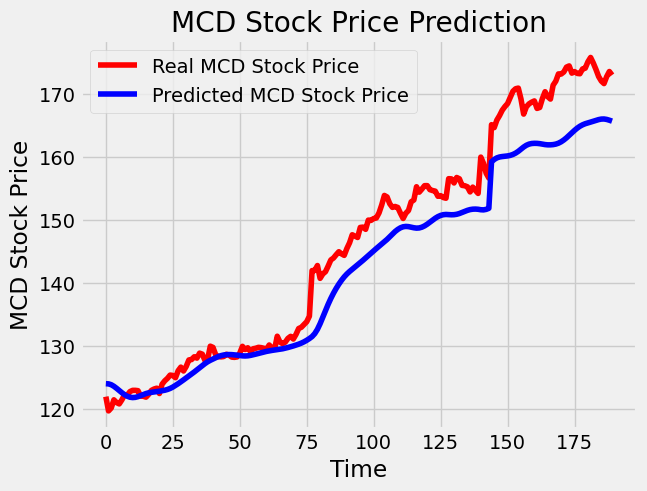

In [60]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [61]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.275615410127776.
